In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

In [62]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

In [63]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [64]:
DecAdData = pd.read_csv('DecemberAdData.csv',header = None)
DecCols = pd.read_csv('DecemberCols.csv',header = None)
M_Cols = pd.read_csv('MarketingCols.csv',header = None)
M_Sales = pd.read_csv('MarketingSales.csv',header = None)

In [72]:
DecAdData.columns = DecCols.values.flatten()
M_Sales.columns = M_Cols.values.flatten()
DecAdData['Date'] = pd.to_datetime(DecAdData['Date'],dayfirst=True)
DecAdData.set_index('Date', inplace=True)
M_Sales['Date'] = pd.to_datetime(M_Sales['Date'],dayfirst=True)
M_Sales.set_index('Date', inplace=True)

In [85]:
x = M_Sales[['PositiveNews','NegativeCoverage','Competition','AdvertisingSpend','0508Line_247','UltraEdition_Available','COVID_Lockdown']].to_numpy()
x

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

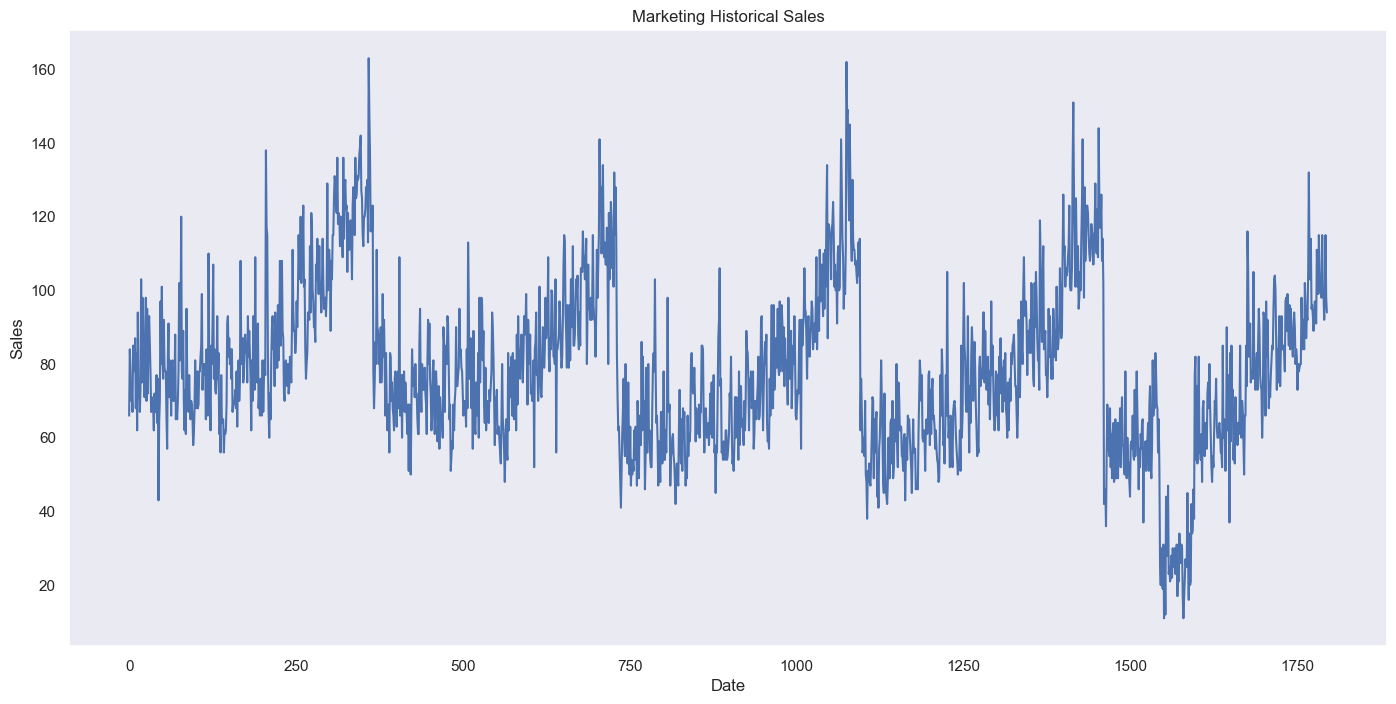

In [67]:
# Plot closing price
plt.figure(figsize=(17, 8))
plt.plot(M_Sales.Sales,zorder=1)
plt.title('Marketing Historical Sales')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.grid(False)
plt.show()

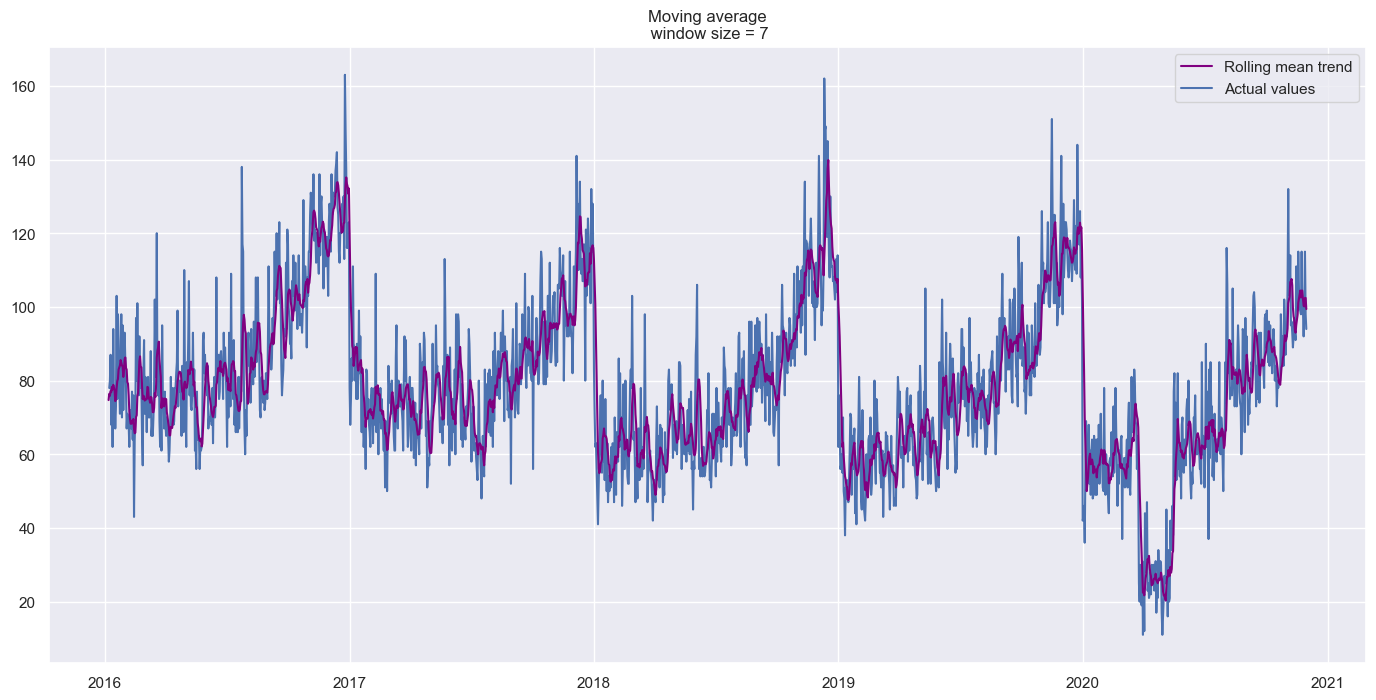

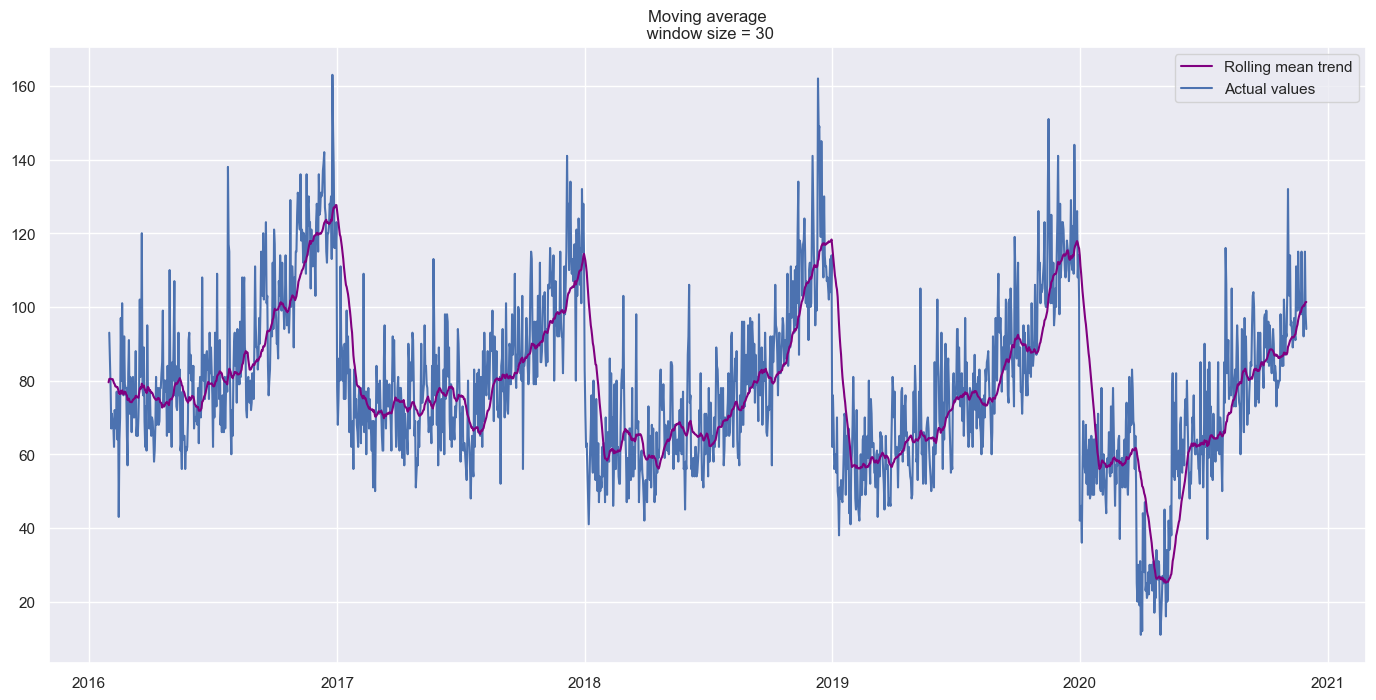

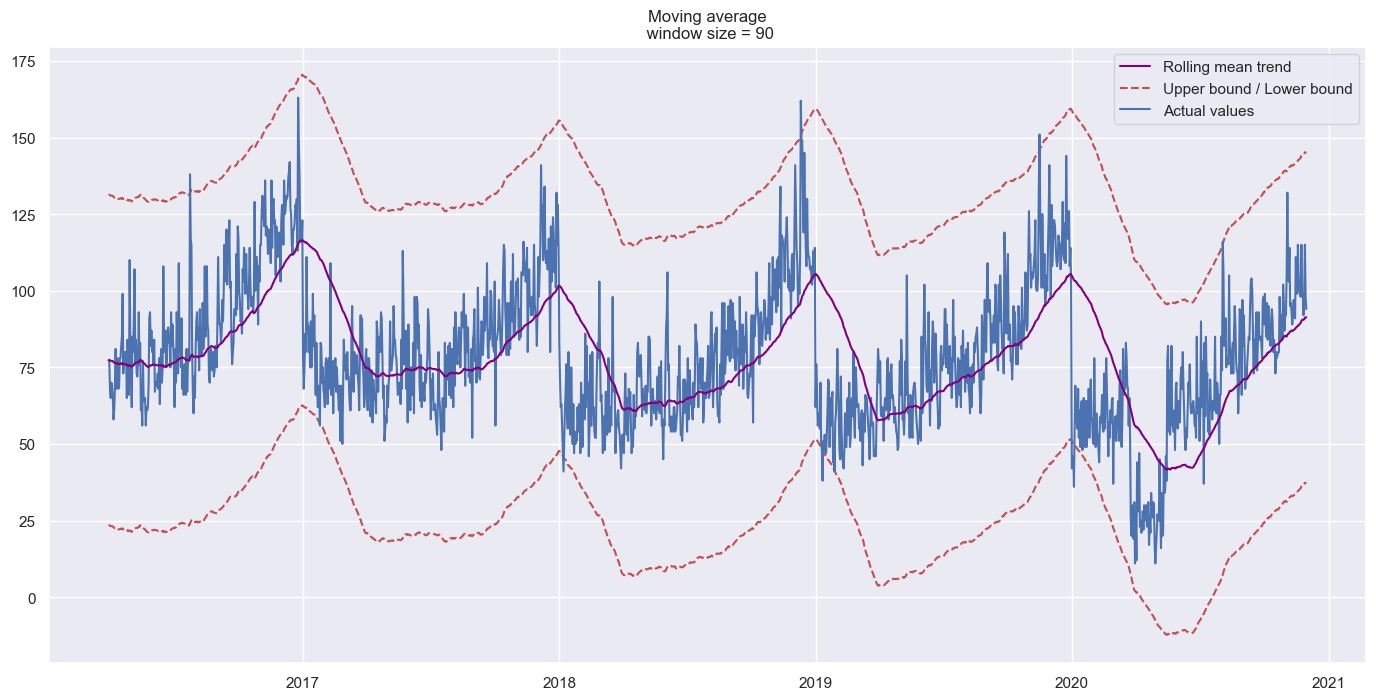

In [41]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'purple', label='Rolling mean trend',zorder=3)
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 7 days (by week)
plot_moving_average(M_Sales.Sales, 7)

#Smooth by the previous month (30 days)
plot_moving_average(M_Sales.Sales, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(M_Sales.Sales, 90, plot_intervals=True)

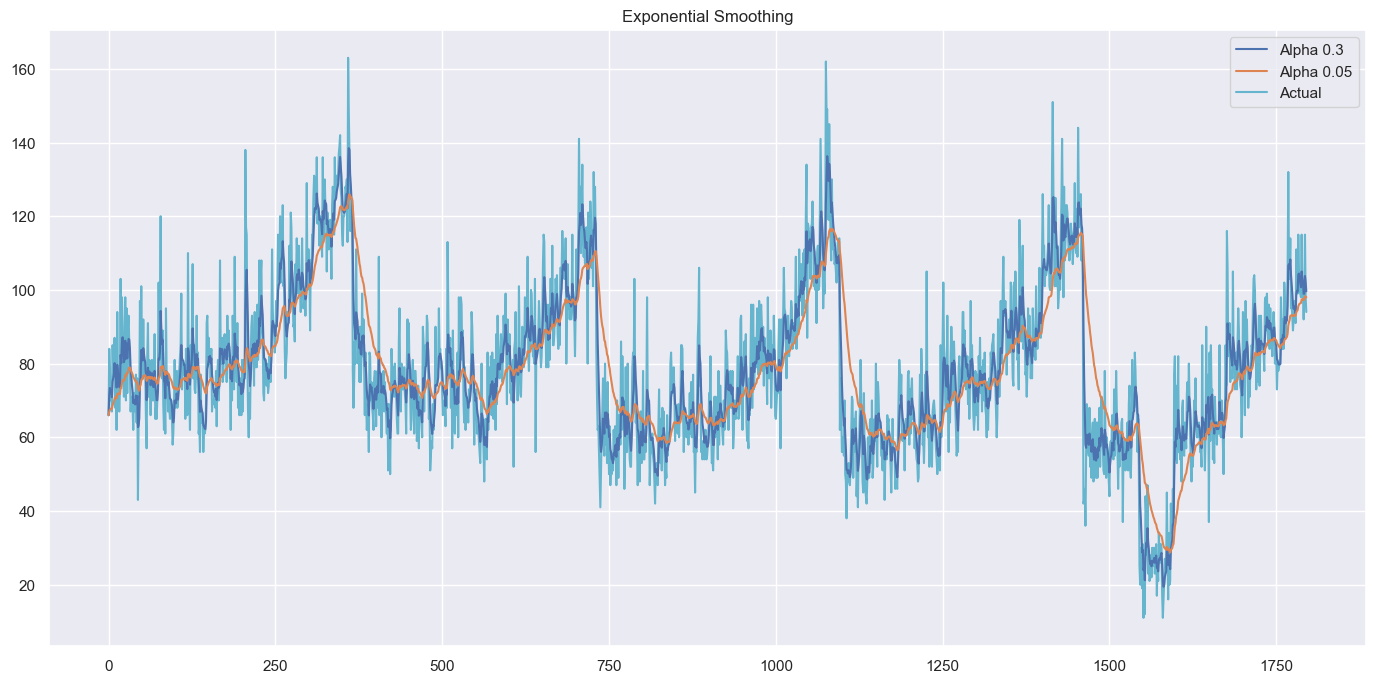

In [47]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha),zorder=3)
    plt.plot(series.values, "c", label = "Actual",zorder=1)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

plot_exponential_smoothing(M_Sales.Sales, [0.3,0.05])

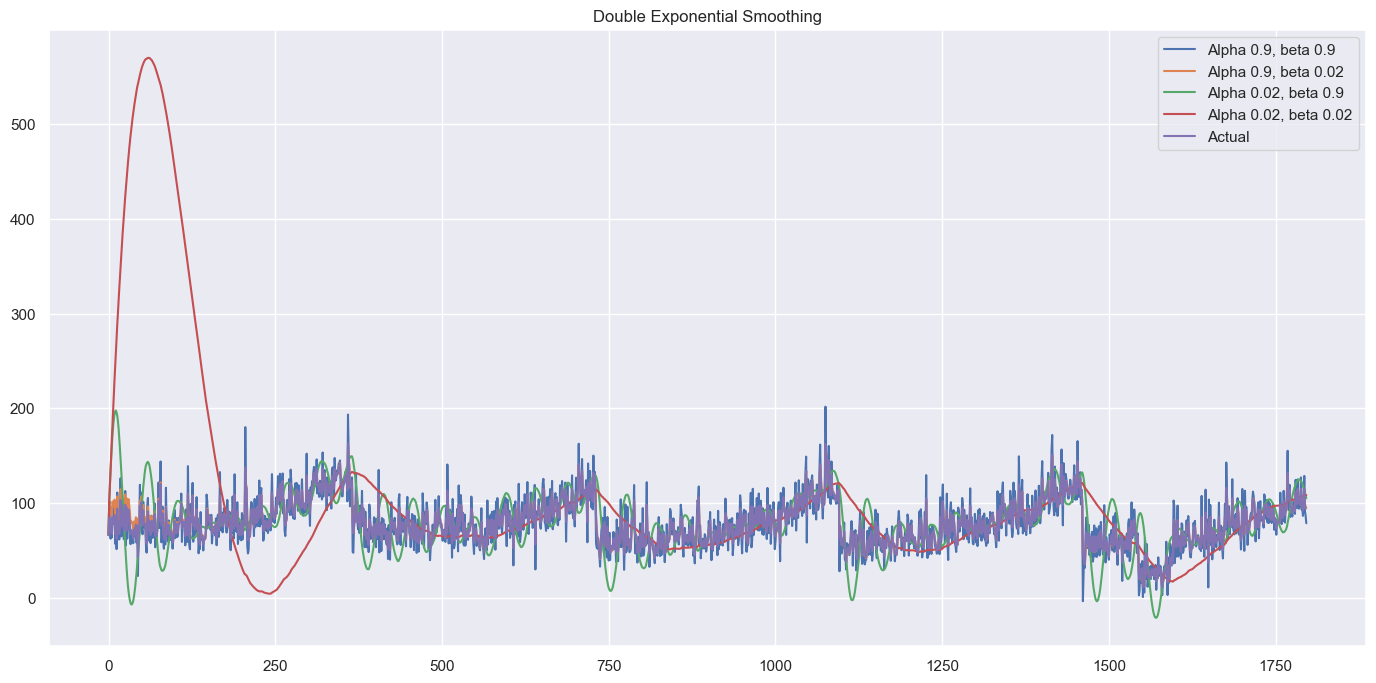

In [54]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(M_Sales.Sales, alphas=[0.9, 0.02], betas=[0.9, 0.02])

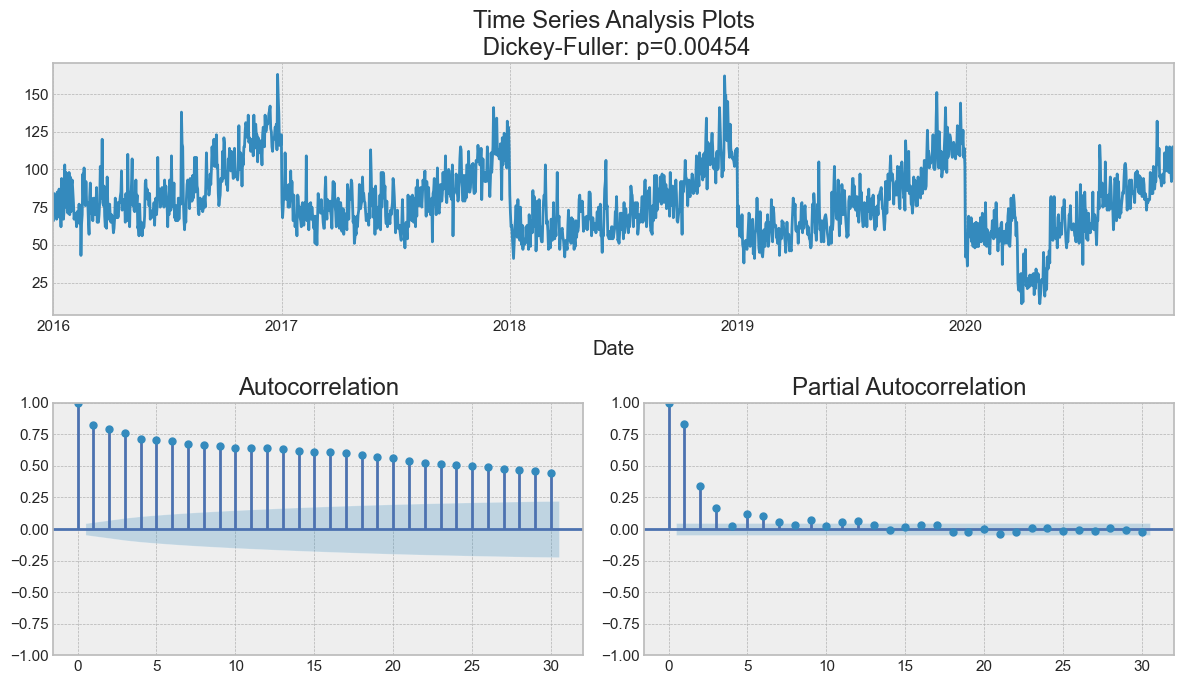

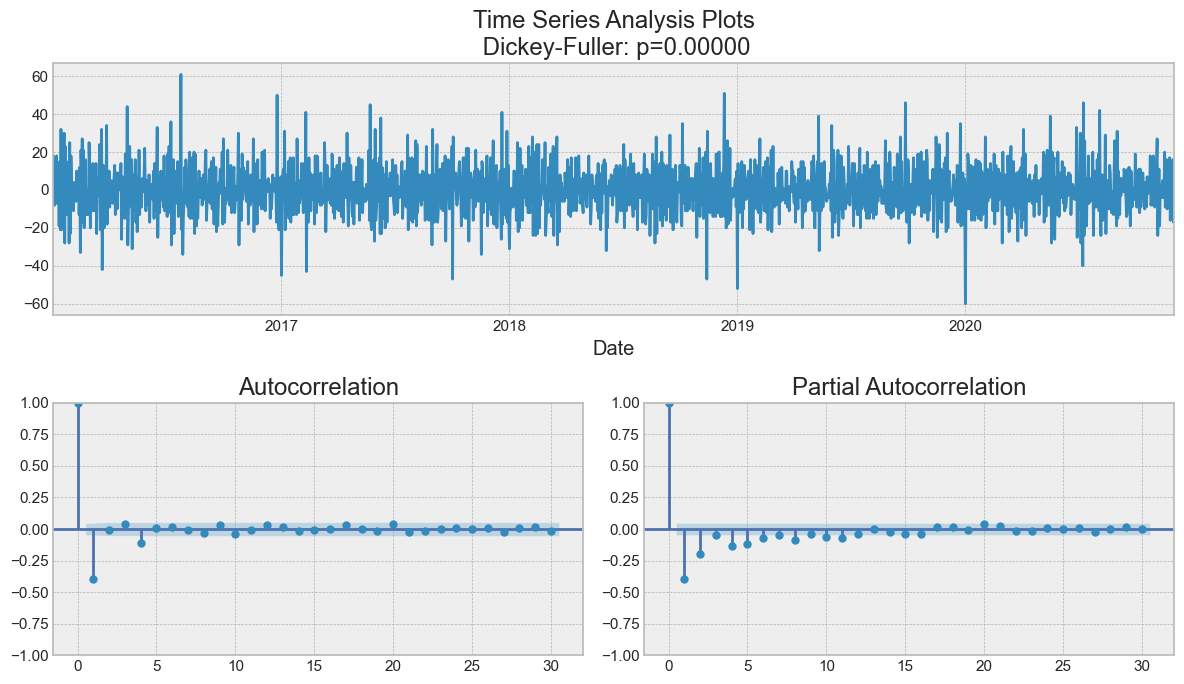

In [55]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(M_Sales.Sales, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = M_Sales.Sales - M_Sales.Sales.shift(1)

tsplot(data_diff[1:], lags=30)

In [57]:
np.empty([3, 5])

array([[4.447e-322, 8.943e-322, 1.349e-321, 2.248e-321, 2.698e-321],
       [3.152e-321, 4.051e-321, 4.501e-321, 4.955e-321, 5.855e-321],
       [6.304e-321, 6.759e-321, 7.663e-321, 8.113e-321, 8.567e-321]])

In [58]:
comparison = pd.DataFrame({'actual': [18.93, 19.23, 19.08, 19.17, 19.11, 19.12],
                          'predicted': [18.96, 18.97, 18.96, 18.92, 18.94, 18.92]}, 
                          index = pd.date_range(start='2018-06-05', periods=6,))

In [59]:
comparison

,actual,predicted
2018-06-05,18.93,18.96
2018-06-06,19.23,18.97
2018-06-07,19.08,18.96
2018-06-08,19.17,18.92
2018-06-09,19.11,18.94
2018-06-10,19.12,18.92
